# Radar Data Preprocessing Pipeline

This notebook prepares radar and IMU data for timestamp calibration and sensor fusion:

1. **Load ROS bag data** (radar, IMU, state)
2. **Fix CPU counter resets** (32-bit overflow correction)
3. **Estimate radar velocity** (Weighted Least Squares)
4. **Integrate IMU acceleration** (with drift correction)
5. **Filter and prepare data** for downstream processing

All core functions are in `radar_velocity_utils.py` for reusability.

In [1]:
import sys
sys.path.append("/workspace/analysis")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

import rosbag_loader
import radar_velocity_utils as rv_utils

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

# Configuration
BAG_PATH = "/workspace/rosbags/2025-12-17-16-02-22.bag"

## Data Loading, and first Inspection

In [2]:
print(f"Loading {BAG_PATH}...\n")
data = rosbag_loader.load_bag_topics(BAG_PATH, verbose=True)



# Time window selection
START_TIME_OFFSET = 31.5  # Skip first N seconds (avoid transients)
DURATION = 15.0           # Analyze this many seconds

# Solver method (WLS vs Huber)
USE_HUBER = True
HUBER_DELTA = 0.5

# Radar filtering thresholds
MIN_INTENSITY = 2.0       # Minimum intensity to consider
MIN_RANGE = 0.2           # Minimum range in meters
MIN_POINTS = 5            # Minimum points for least squares

# Signal processing
IMU_HIGHPASS_CUTOFF = 0.2   # Hz - removes integration drift
RADAR_LOWPASS_CUTOFF = 3.0  # Hz - smooths radar estimates

Loading /workspace/rosbags/2025-12-17-16-02-22.bag...


Loading rosbag: 2025-12-17-16-02-22.bag
Duration: 48.59s
  Loading /mocap/angrybird2/pose...
  Loading /mocap/angrybird2/accel...
  Loading /angrybird2/agiros_pilot/state...
  Loading /angrybird2/agiros_pilot/odometry...
  Loading /angrybird2/imu...
  Loading /ti_mmwave/radar_scan_pcl_0...
  Loading /mmWaveDataHdl/RScanVelocity...
  Done!



### Data Inspection

In [3]:
radar_frames_raw = data.radar_velocity.copy()

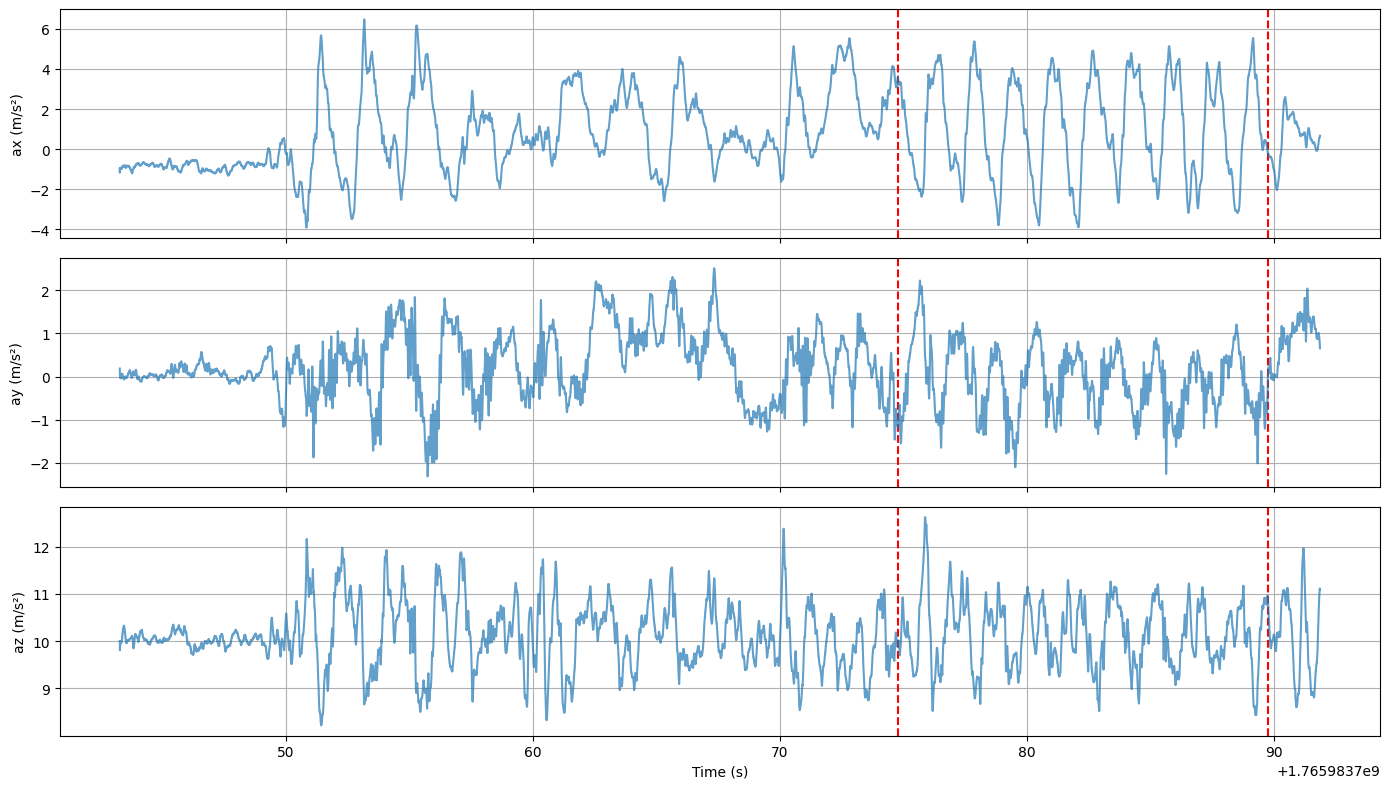

In [4]:
# Plot IMU acceleration
imu_df = pd.DataFrame([imu.to_dict() for imu in data.imu_data])

t_start = data.start_time + START_TIME_OFFSET
t_end = t_start + DURATION


fig, axes = plt.subplots(3, 1, sharex=True)

for ax in axes:
    ax.axvline(t_start, linestyle='--', c="red")
    ax.axvline(t_end, linestyle='--', c="red")

axes[0].plot(imu_df['timestamp'], imu_df['ax'], alpha=0.7)
axes[0].set_ylabel('ax (m/s²)')
axes[0].grid(True)

axes[1].plot(imu_df['timestamp'], imu_df['ay'], alpha=0.7)
axes[1].set_ylabel('ay (m/s²)')
axes[1].grid(True)

axes[2].plot(imu_df['timestamp'], imu_df['az'], alpha=0.7)
axes[2].set_ylabel('az (m/s²)')
axes[2].set_xlabel('Time (s)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

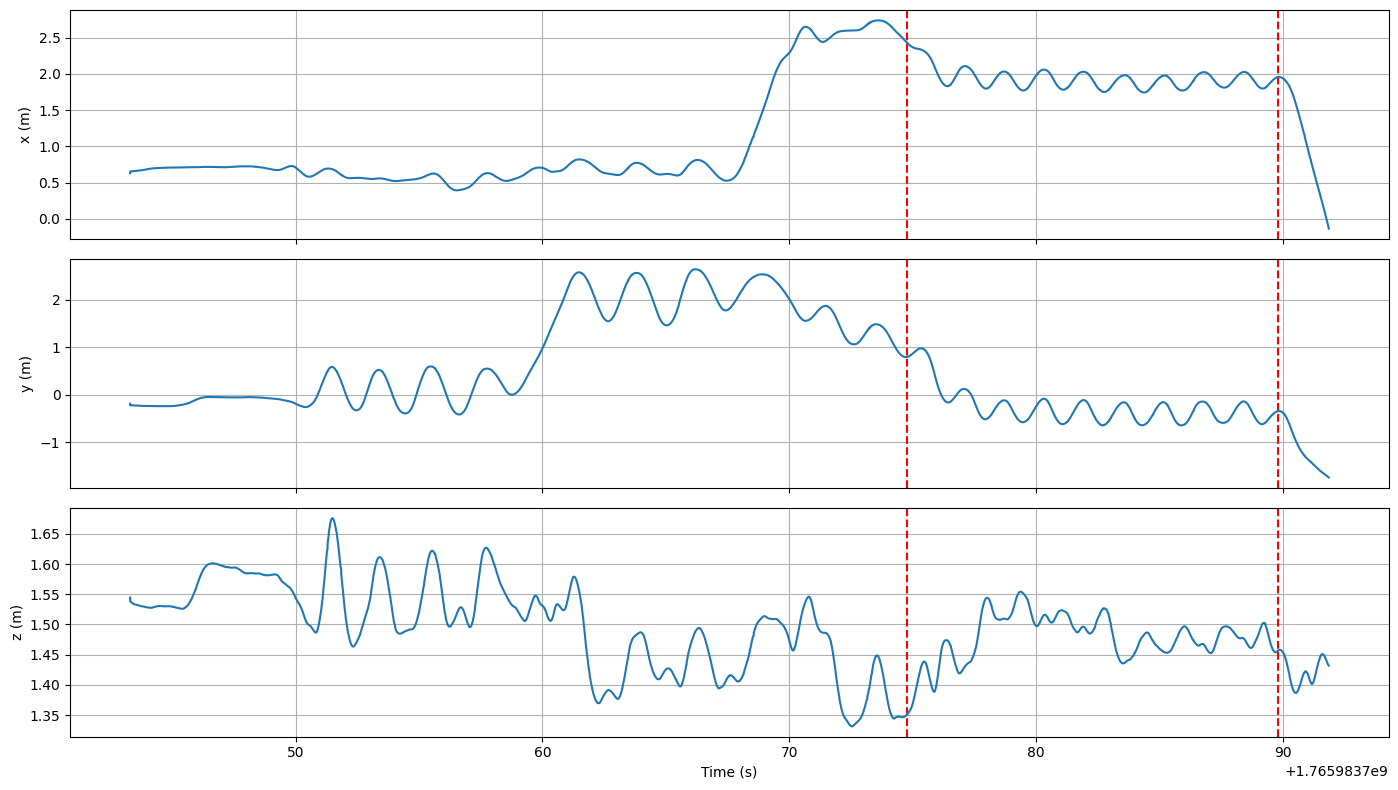

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R


mocap_pose_df = pd.DataFrame([pose.to_dict() for pose in data.mocap_pose])

t = mocap_pose_df['timestamp'].to_numpy()
p = mocap_pose_df[['x', 'y', 'z']].to_numpy()

# world-frame velocity (central differences)
v_world = np.gradient(p, t, axis=0)

# quaternions (scipy expects [x, y, z, w])
q = mocap_pose_df[['qx', 'qy', 'qz', 'qw']].to_numpy()
rot = R.from_quat(q)

# rotate world velocity into body frame
v_body = rot.apply(v_world)

# body x velocity
v_body_x = v_body[:, 0]

fig, axs = plt.subplots(3, 1, sharex=True)
for ax in axs:
    ax.axvline(t_start, linestyle='--', c="red")
    ax.axvline(t_end, linestyle='--', c="red")
axs[0].plot(t, p[:, 0])
axs[0].set_ylabel("x (m)")
axs[0].grid(True)
axs[1].plot(t, p[:, 1])
axs[1].set_ylabel("y (m)")
axs[1].grid(True)
axs[2].plot(t, p[:, 2])
axs[2].set_ylabel("z (m)")
axs[2].set_xlabel("Time (s)")
axs[2].grid(True)
plt.tight_layout()
plt.show()



Index(['timestamp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'qx', 'qy', 'qz', 'qw',
       'wx', 'wy', 'wz', 'ax', 'ay', 'az', 'motor1', 'motor2', 'motor3',
       'motor4'],
      dtype='object')


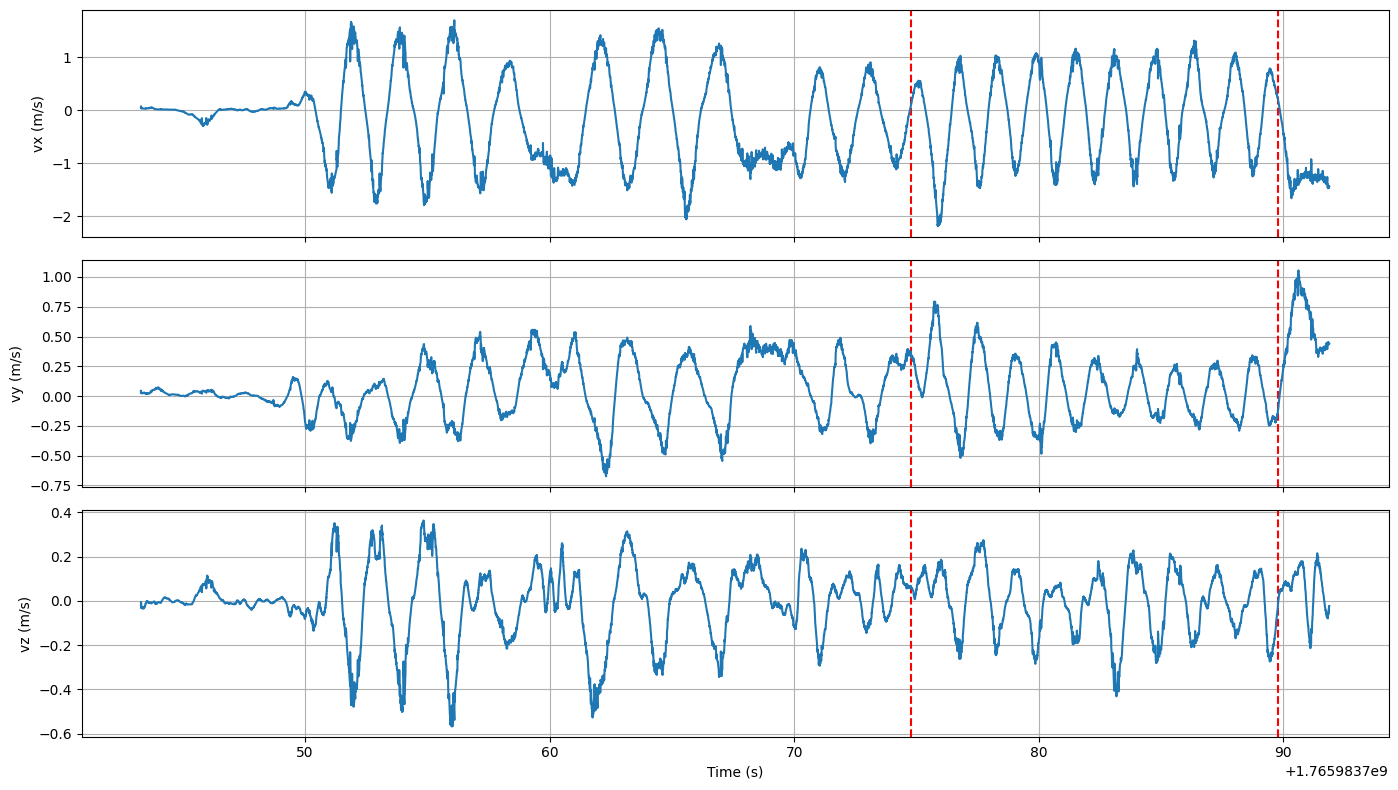

In [6]:
agiros_state_df = pd.DataFrame([state.to_dict() for state in data.agiros_state])
print(agiros_state_df.columns)

t = agiros_state_df['timestamp'].to_numpy()
v = agiros_state_df[['vx', 'vy', 'vz']].to_numpy()


v_world = agiros_state_df[['vx', 'vy', 'vz']].to_numpy()
q = agiros_state_df[['qx', 'qy', 'qz', 'qw']].to_numpy()

rot = R.from_quat(q)

# world -> body
v_body = rot.inv().apply(v_world)

v_body_x = v_body[:, 0]
v_body_y = v_body[:, 1]
v_body_z = v_body[:, 2]

fig, axs = plt.subplots(3, 1, sharex=True)
for ax in axs:
    ax.axvline(t_start, linestyle='--', c="red")
    ax.axvline(t_end, linestyle='--', c="red")
axs[0].plot(t, v_body_x)
axs[0].set_ylabel("vx (m/s)")
axs[0].grid(True)
axs[1].plot(t, v_body_y)
axs[1].set_ylabel("vy (m/s)")
axs[1].grid(True)
axs[2].plot(t, v_body_z)
axs[2].set_ylabel("vz (m/s)")
axs[2].set_xlabel("Time (s)")
axs[2].grid(True)
plt.tight_layout()
plt.show()



Analyzing 449 radar frames in time window

Total points: 2469
Intensity range: [11.2, 30.4]
Range (distance) range: [0.62, 8.00] m

=== Velocity Component Statistics ===

Vx:
  Mean:       -0.022 m/s
  Std:         0.477 m/s
  Skewness:   -0.554
  Kurtosis:   -0.237
  Range:    [-1.98, 0.99] m/s

Vy:
  Mean:       -0.001 m/s
  Std:         0.213 m/s
  Skewness:    0.813
  Kurtosis:    4.703
  Range:    [-0.57, 1.64] m/s

Vz:
  Mean:        0.008 m/s
  Std:         0.425 m/s
  Skewness:    0.111
  Kurtosis:   -1.467
  Range:    [-0.72, 1.28] m/s


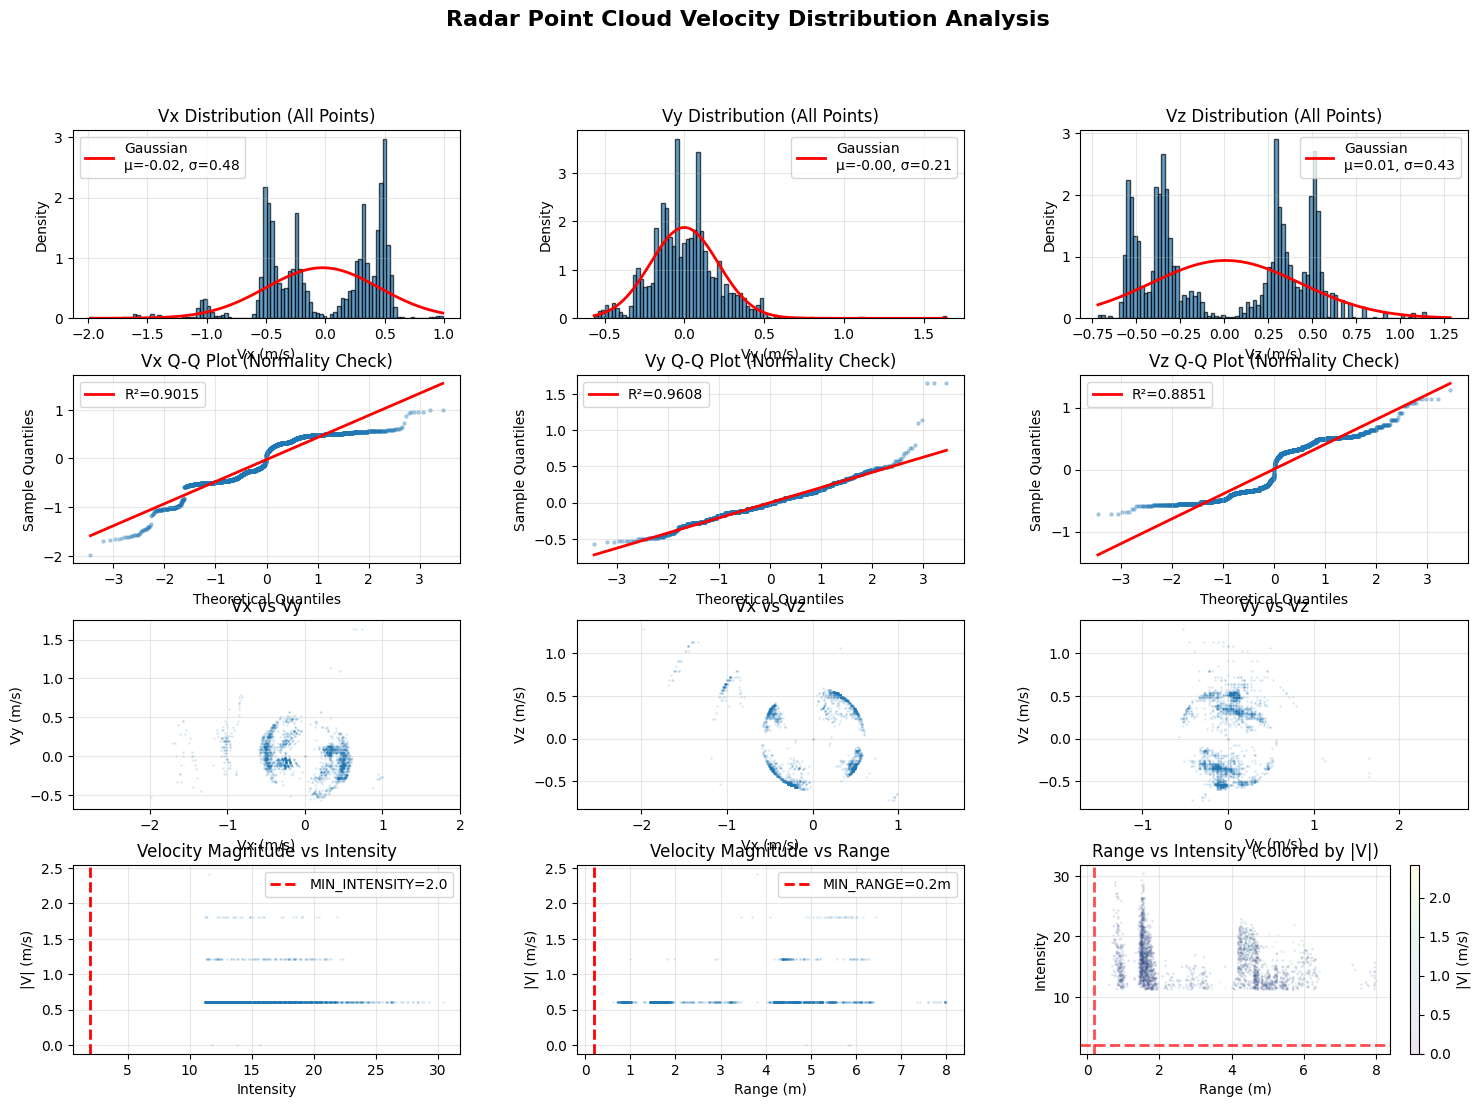

In [7]:
# Analyze velocity distribution of radar points across frames
# For each point: v_xyz = v_rad * (r / |r|)

from scipy import stats as sp_stats

# Collect velocity components from multiple frames
vx_all = []
vy_all = []
vz_all = []
intensities_all = []
ranges_all = []

# Sample frames from the time window
sample_frames = [f for f in data.radar_velocity if t_start <= f.timestamp <= t_end]
print(f"Analyzing {len(sample_frames)} radar frames in time window")

for frame in sample_frames:
    if frame.velocities is None or frame.positions is None:
        continue
    
    for i in range(len(frame.velocities)):
        x, y, z = frame.positions[i]
        v_rad = frame.velocities[i]
        
        # Range (distance to point)
        r = np.sqrt(x**2 + y**2 + z**2)
        
        if r > 0:  # Avoid division by zero
            # Unit direction vector
            r_hat = np.array([x/r, y/r, z/r])
            
            # Velocity vector: v = v_rad * r_hat
            v_xyz = v_rad * r_hat
            
            vx_all.append(v_xyz[0])
            vy_all.append(v_xyz[1])
            vz_all.append(v_xyz[2])
            intensities_all.append(frame.intensities[i] if frame.intensities is not None else 0)
            ranges_all.append(r)

vx_all = np.array(vx_all)
vy_all = np.array(vy_all)
vz_all = np.array(vz_all)
intensities_all = np.array(intensities_all)
ranges_all = np.array(ranges_all)

print(f"\nTotal points: {len(vx_all)}")
print(f"Intensity range: [{intensities_all.min():.1f}, {intensities_all.max():.1f}]")
print(f"Range (distance) range: [{ranges_all.min():.2f}, {ranges_all.max():.2f}] m")

# Statistics for each component
print(f"\n=== Velocity Component Statistics ===")
for name, d in [('Vx', vx_all), ('Vy', vy_all), ('Vz', vz_all)]:
    print(f"\n{name}:")
    print(f"  Mean:     {np.mean(d):>8.3f} m/s")
    print(f"  Std:      {np.std(d):>8.3f} m/s")
    print(f"  Skewness: {sp_stats.skew(d):>8.3f}")
    print(f"  Kurtosis: {sp_stats.kurtosis(d):>8.3f}")
    print(f"  Range:    [{np.min(d):.2f}, {np.max(d):.2f}] m/s")

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Row 1: Histograms with Gaussian fit
for i, (name, d) in enumerate([('Vx', vx_all), ('Vy', vy_all), ('Vz', vz_all)]):
    ax = fig.add_subplot(gs[0, i])
    
    # Histogram
    counts, bins, _ = ax.hist(d, bins=100, alpha=0.7, edgecolor='black', density=True)
    
    # Fit Gaussian
    mu, sigma = np.mean(d), np.std(d)
    x_fit = np.linspace(d.min(), d.max(), 200)
    y_fit = sp_stats.norm.pdf(x_fit, mu, sigma)
    ax.plot(x_fit, y_fit, 'r-', linewidth=2, label=f'Gaussian\nμ={mu:.2f}, σ={sigma:.2f}')
    
    ax.set_xlabel(f'{name} (m/s)')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Distribution (All Points)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 2: Q-Q plots (normality test)
for i, (name, d) in enumerate([('Vx', vx_all), ('Vy', vy_all), ('Vz', vz_all)]):
    ax = fig.add_subplot(gs[1, i])
    
    (quantiles, values), (slope, intercept, r) = sp_stats.probplot(d, dist="norm", plot=None)
    ax.scatter(quantiles, values, alpha=0.3, s=5)
    ax.plot(quantiles, slope * quantiles + intercept, 'r-', linewidth=2, 
            label=f'R²={r**2:.4f}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.set_title(f'{name} Q-Q Plot (Normality Check)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 3: 2D scatter plots
ax = fig.add_subplot(gs[2, 0])
ax.scatter(vx_all, vy_all, alpha=0.1, s=1)
ax.set_xlabel('Vx (m/s)')
ax.set_ylabel('Vy (m/s)')
ax.set_title('Vx vs Vy')
ax.grid(True, alpha=0.3)
ax.axis('equal')

ax = fig.add_subplot(gs[2, 1])
ax.scatter(vx_all, vz_all, alpha=0.1, s=1)
ax.set_xlabel('Vx (m/s)')
ax.set_ylabel('Vz (m/s)')
ax.set_title('Vx vs Vz')
ax.grid(True, alpha=0.3)
ax.axis('equal')

ax = fig.add_subplot(gs[2, 2])
ax.scatter(vy_all, vz_all, alpha=0.1, s=1)
ax.set_xlabel('Vy (m/s)')
ax.set_ylabel('Vz (m/s)')
ax.set_title('Vy vs Vz')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Row 4: Velocity vs Intensity and Range
ax = fig.add_subplot(gs[3, 0])
v_mag = np.sqrt(vx_all**2 + vy_all**2 + vz_all**2)
ax.scatter(intensities_all, v_mag, alpha=0.1, s=1)
ax.axvline(MIN_INTENSITY, color='r', linestyle='--', linewidth=2, label=f'MIN_INTENSITY={MIN_INTENSITY}')
ax.set_xlabel('Intensity')
ax.set_ylabel('|V| (m/s)')
ax.set_title('Velocity Magnitude vs Intensity')
ax.legend()
ax.grid(True, alpha=0.3)

ax = fig.add_subplot(gs[3, 1])
ax.scatter(ranges_all, v_mag, alpha=0.1, s=1)
ax.axvline(MIN_RANGE, color='r', linestyle='--', linewidth=2, label=f'MIN_RANGE={MIN_RANGE}m')
ax.set_xlabel('Range (m)')
ax.set_ylabel('|V| (m/s)')
ax.set_title('Velocity Magnitude vs Range')
ax.legend()
ax.grid(True, alpha=0.3)

ax = fig.add_subplot(gs[3, 2])
ax.scatter(ranges_all, intensities_all, alpha=0.1, s=1, c=v_mag, cmap='viridis')
ax.axvline(MIN_RANGE, color='r', linestyle='--', linewidth=2, alpha=0.7)
ax.axhline(MIN_INTENSITY, color='r', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Range (m)')
ax.set_ylabel('Intensity')
ax.set_title('Range vs Intensity (colored by |V|)')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('|V| (m/s)')
ax.grid(True, alpha=0.3)

plt.suptitle('Radar Point Cloud Velocity Distribution Analysis', fontsize=16, fontweight='bold')
plt.show()

Measured Doppler Velocity:

$$v_{d,i} = \vec{v}_{body} \cdot \vec{u}_{i} + \eta_i$$

- $v_{d,i}$ is the measured Doppler
- $\vec{u}_{i}$ is the unit Line-of-Sight (LOS) vector
- $\eta_i$ is the measurement noise (hopefully gaussian)


To project this back to the body X-axis, I can invert the equation:

$$v_{x,i} = \frac{v_{d,i}}{u_{x,i}}$$

The problem: For directions with large angles (e.g., $85^\circ$ azimuth), $u_{x,i}$ becomes very close to 0. Dividing the noise $\eta_i$ by a near-zero number amplifies it massively.

=== Points Per Frame Distribution ===

Total frames:          1396
Min points:            1
Max points:            15
Mean points:           4.8
Median points:         5.0
Frames with < 5 pts:   674 (48.3%)


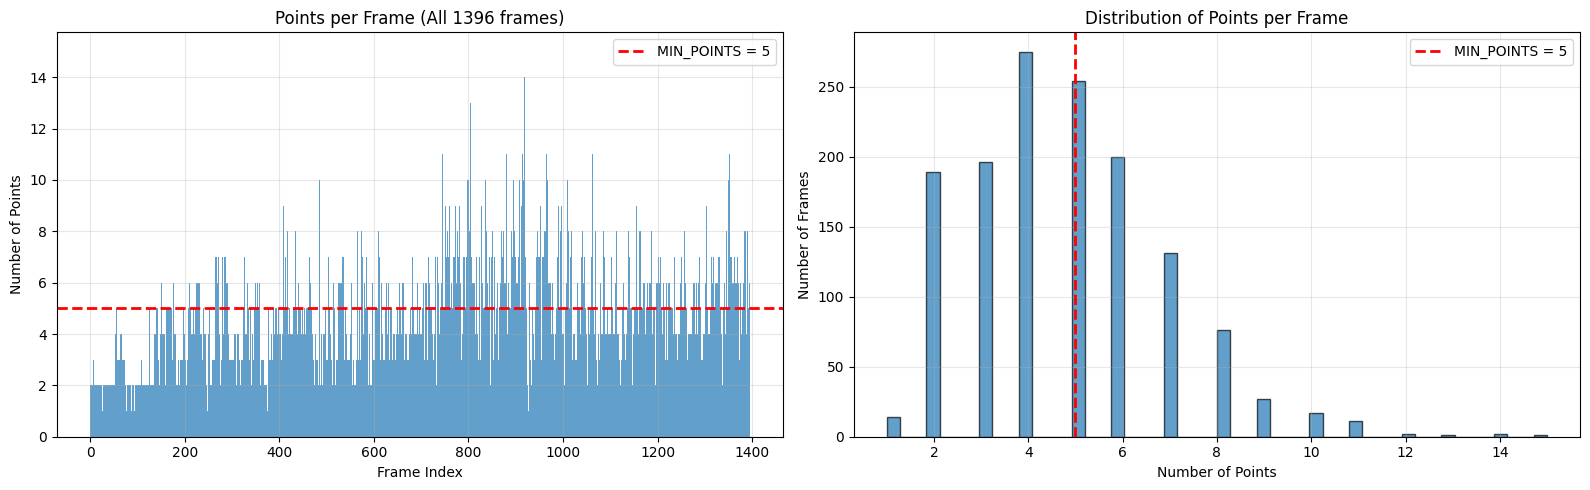


=== Applying MIN_POINTS Filter ===

Frames before filter:  1396
Frames after filter:   722
Frames removed:        674 (48.3%)

=== Body Velocity Projection (Sample Frames) ===

Analyzing 6 sample frames:
  Frame 0: 5 points, mean=-0.15 m/s, std=0.37 m/s
  Frame 144: 6 points, mean=0.45 m/s, std=0.40 m/s
  Frame 288: 7 points, mean=0.33 m/s, std=0.25 m/s
  Frame 432: 9 points, mean=0.08 m/s, std=0.43 m/s
  Frame 576: 7 points, mean=0.12 m/s, std=0.38 m/s
  Frame 721: 7 points, mean=-0.11 m/s, std=0.35 m/s


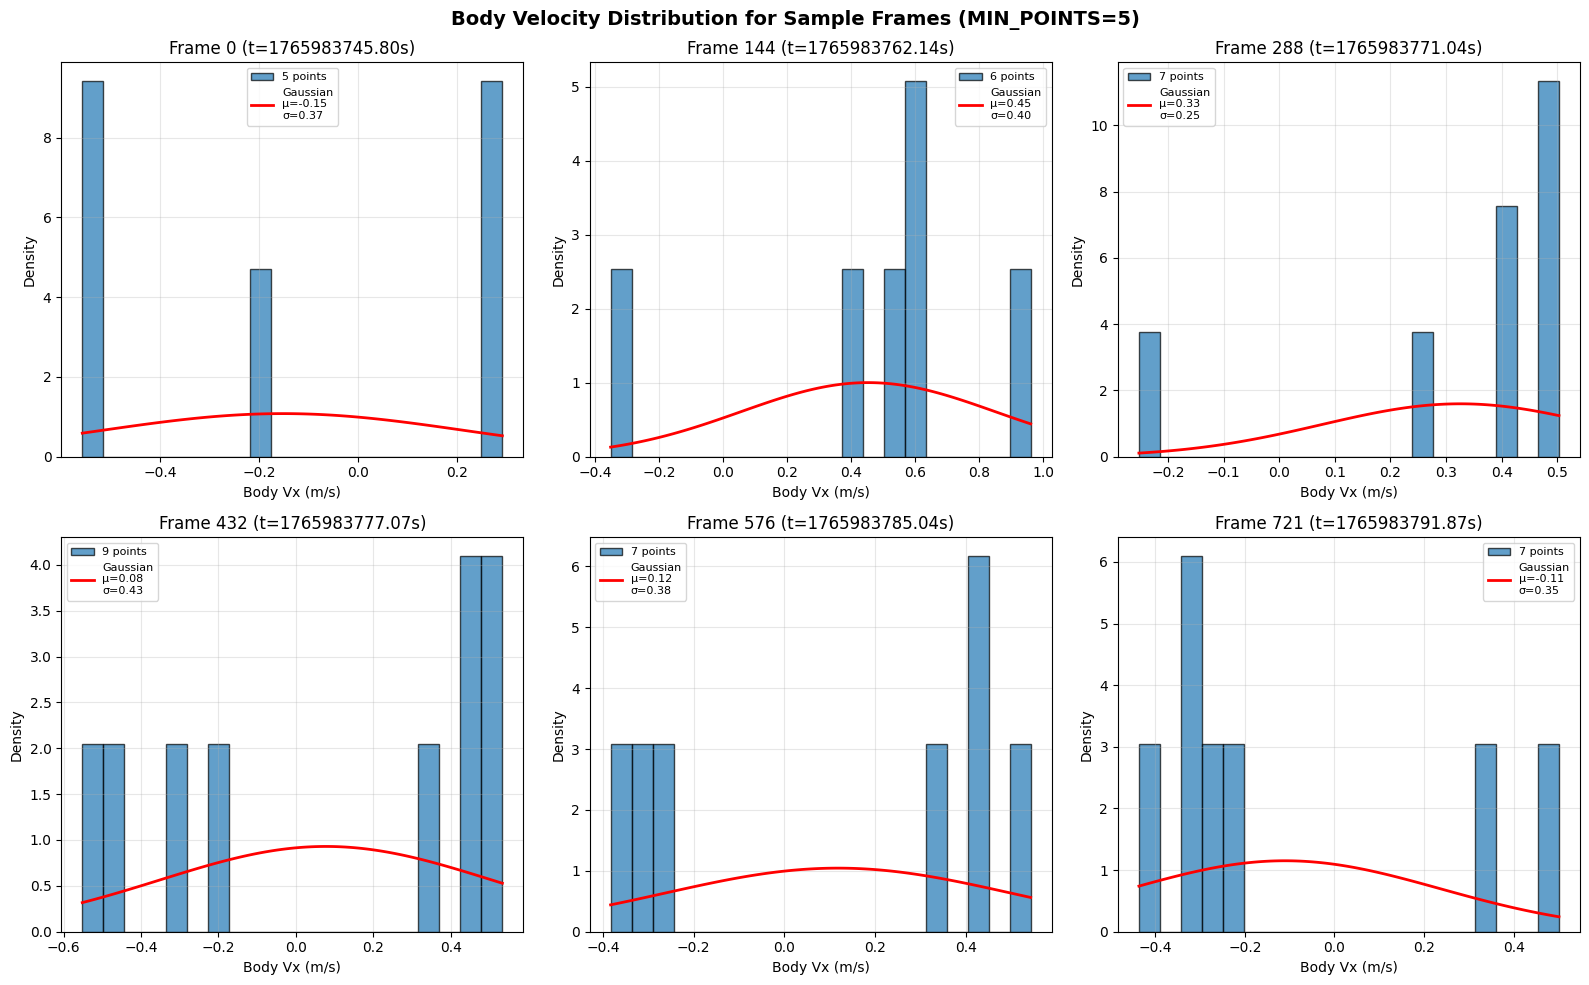


💡 Observations:
  - Each frame's body velocities show approximately Gaussian distribution
  - This validates the Weighted Least Squares approach for velocity estimation
  - Outliers/noise are still present → need intensity and range filtering


In [8]:
# Step 1: Bar chart showing points per frame distribution
print("=== Points Per Frame Distribution ===\n")

# Count points in each frame
points_per_frame = [len(f.positions) if f.positions is not None else 0 
                    for f in radar_frames_raw]

print(f"Total frames:          {len(points_per_frame)}")
print(f"Min points:            {min(points_per_frame)}")
print(f"Max points:            {max(points_per_frame)}")
print(f"Mean points:           {np.mean(points_per_frame):.1f}")
print(f"Median points:         {np.median(points_per_frame):.1f}")
print(f"Frames with < 5 pts:   {sum(1 for n in points_per_frame if n < 5)} ({100*sum(1 for n in points_per_frame if n < 5)/len(points_per_frame):.1f}%)")

# Create bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Bar chart of all frames
axes[0].bar(range(len(points_per_frame)), points_per_frame, width=1.0, alpha=0.7)
axes[0].axhline(MIN_POINTS, color='r', linestyle='--', linewidth=2, 
                label=f'MIN_POINTS = {MIN_POINTS}')
axes[0].set_xlabel('Frame Index')
axes[0].set_ylabel('Number of Points')
axes[0].set_title(f'Points per Frame (All {len(points_per_frame)} frames)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Histogram of distribution
axes[1].hist(points_per_frame, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(MIN_POINTS, color='r', linestyle='--', linewidth=2,
                label=f'MIN_POINTS = {MIN_POINTS}')
axes[1].set_xlabel('Number of Points')
axes[1].set_ylabel('Number of Frames')
axes[1].set_title('Distribution of Points per Frame')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Step 2: Filter frames with minimum points
print(f"\n=== Applying MIN_POINTS Filter ===\n")
filtered_frames = [f for f in radar_frames_raw 
                   if f.positions is not None and len(f.positions) >= MIN_POINTS]

print(f"Frames before filter:  {len(radar_frames_raw)}")
print(f"Frames after filter:   {len(filtered_frames)}")
print(f"Frames removed:        {len(radar_frames_raw) - len(filtered_frames)} ({100*(len(radar_frames_raw) - len(filtered_frames))/len(radar_frames_raw):.1f}%)")


# Step 3: Project points to body velocity for a few example frames
print(f"\n=== Body Velocity Projection (Sample Frames) ===\n")

# Select a few frames evenly spaced
num_samples = min(6, len(filtered_frames))
sample_indices = np.linspace(0, len(filtered_frames)-1, num_samples, dtype=int)

print(f"Analyzing {num_samples} sample frames:")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, frame_idx in enumerate(sample_indices):
    frame = filtered_frames[frame_idx]
    # Extract point data
    positions = np.array(frame.positions)
    velocities = np.array(frame.velocities)
    
    # Project each point to body velocity: v_body = v_rad * (r / |r|)
    body_velocities_x = []
    
    for i in range(len(positions)):
        x, y, z = positions[i]
        v_rad = velocities[i]
        
        # Range (distance)
        r = np.sqrt(x**2 + y**2 + z**2)
        
        if r > 0:
            # Unit direction vector
            r_hat = np.array([x/r, y/r, z/r])
            
            # Body velocity (x-component): v_body_x = v_rad * r_hat[0]
            v_body_x = v_rad * r_hat[0]
            body_velocities_x.append(v_body_x)
    
    body_velocities_x = np.array(body_velocities_x)
    
    # Statistics
    mean_v = np.mean(body_velocities_x)
    std_v = np.std(body_velocities_x)
    
    print(f"  Frame {frame_idx}: {len(body_velocities_x)} points, "
          f"mean={mean_v:.2f} m/s, std={std_v:.2f} m/s")
    
    # Plot histogram with Gaussian overlay
    axes[idx].hist(body_velocities_x, bins=20, alpha=0.7, edgecolor='black', 
                   density=True, label=f'{len(body_velocities_x)} points')
    
    # Fit Gaussian
    from scipy import stats as sp_stats
    x_fit = np.linspace(body_velocities_x.min(), body_velocities_x.max(), 100)
    gaussian_fit = sp_stats.norm.pdf(x_fit, mean_v, std_v)
    axes[idx].plot(x_fit, gaussian_fit, 'r-', linewidth=2, 
                   label=f'Gaussian\nμ={mean_v:.2f}\nσ={std_v:.2f}')
    
    axes[idx].set_xlabel('Body Vx (m/s)')
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'Frame {frame_idx} (t={frame.timestamp:.2f}s)')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle(f'Body Velocity Distribution for Sample Frames (MIN_POINTS={MIN_POINTS})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("  - Each frame's body velocities show approximately Gaussian distribution")
print("  - This validates the Weighted Least Squares approach for velocity estimation")
print("  - Outliers/noise are still present → need intensity and range filtering")

## Data Preparation

### Step 1: Crop Data from ROS Bag

In [9]:
# Filter to time window of interest
t_start = data.start_time + START_TIME_OFFSET
t_end = t_start + DURATION

print(f"\n=== Time Window Selection ===")
print(f"Bag start:      {data.start_time:.2f} s")
print(f"Analysis start: {t_start:.2f} s (offset: {START_TIME_OFFSET:.1f} s)")
print(f"Analysis end:   {t_end:.2f} s")

# Filter all data to window
data.imu_data = [imu for imu in data.imu_data if t_start <= imu.timestamp <= t_end]
data.agiros_state = [state for state in data.agiros_state if t_start <= state.timestamp <= t_end]
data.radar_velocity = [radar for radar in data.radar_velocity if t_start <= radar.timestamp <= t_end]

print(f"\n=== Data Summary (Filtered) ===")
print(f"IMU samples:          {len(data.imu_data)}")
print(f"Agiros state samples: {len(data.agiros_state)}")
print(f"Radar frames:         {len(data.radar_velocity)}")
if len(data.imu_data) > 0:
    duration = data.imu_data[-1].timestamp - data.imu_data[0].timestamp
    print(f"Duration:             {duration:.2f} s")


=== Time Window Selection ===
Bag start:      1765983743.29 s
Analysis start: 1765983774.79 s (offset: 31.5 s)
Analysis end:   1765983789.79 s

=== Data Summary (Filtered) ===
IMU samples:          14917
Agiros state samples: 4503
Radar frames:         449
Duration:             15.00 s


### Step 2: Extract Agiros State (Validation Reference)


=== Agiros State ===
Samples:     4503
Sample rate: 300.2 Hz
Vx range:    [-0.88, 0.78] m/s


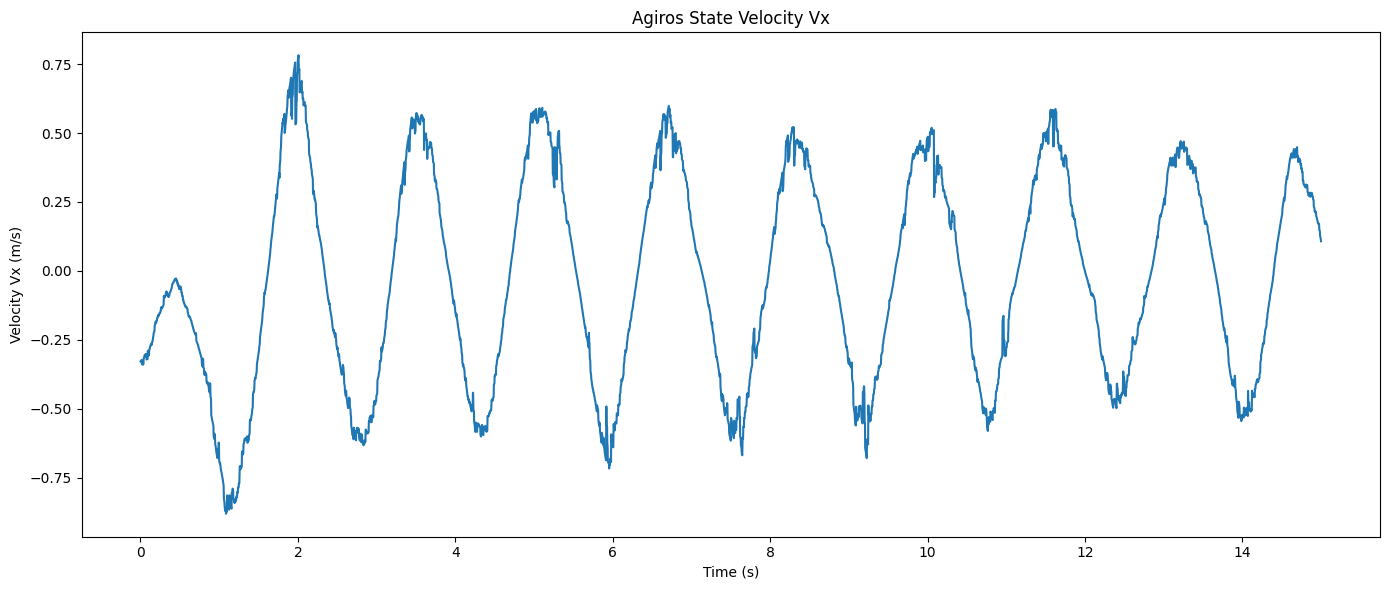

In [10]:
# Extract state velocity
state_times = np.array([s.timestamp for s in data.agiros_state])
state_vx = np.array([s.velocity[0] for s in data.agiros_state])

print(f"\n=== Agiros State ===")
print(f"Samples:     {len(state_times)}")
print(f"Sample rate: {len(state_times) / (state_times[-1] - state_times[0]):.1f} Hz")
print(f"Vx range:    [{state_vx.min():.2f}, {state_vx.max():.2f}] m/s")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(state_times - t_start, state_vx, label="Agiros State Vx")
ax.set_title("Agiros State Velocity Vx")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity Vx (m/s)")
plt.tight_layout()
plt.show()

### Step 3: Integrate IMU Acceleration & Apply Drift Correction (Highpass Filter)

- Integrate X-axis acceleration to get velocity reference signal.
- Remove low-frequency drift from integrated velocity using highpass filter.

In [11]:
imu_result = rv_utils.integrate_imu_acceleration(data.imu_data, axis='x')

print(f"=== IMU Integration ===\n")
print(f"Samples:          {len(imu_result['times'])}")
print(f"Estimated bias:   {imu_result['bias']:.4f} m/s²")
print(f"Sample rate:      {len(imu_result['times']) / (imu_result['times'][-1] - imu_result['times'][0]):.1f} Hz")
print(f"Raw velocity range: [{imu_result['velocity_raw'].min():.2f}, {imu_result['velocity_raw'].max():.2f}] m/s")

# Compute sample rate
sample_rate_imu = len(imu_result['times']) / (imu_result['times'][-1] - imu_result['times'][0])


# Apply highpass filter
imu_result['velocity_filtered'] = rv_utils.apply_highpass_filter(
    imu_result['velocity_raw'],
    cutoff_hz=IMU_HIGHPASS_CUTOFF,
    sample_rate_hz=sample_rate_imu,
    order=2
)

print(f"\n=== Drift Correction ===\n")
print(f"Highpass cutoff:      {IMU_HIGHPASS_CUTOFF} Hz")
print(f"Filtered velocity range: [{imu_result['velocity_filtered'].min():.2f}, {imu_result['velocity_filtered'].max():.2f}] m/s")


=== IMU Integration ===

Samples:          14917
Estimated bias:   0.0000 m/s²
Sample rate:      994.6 Hz
Raw velocity range: [-1.84, 1.57] m/s

=== Drift Correction ===

Highpass cutoff:      0.2 Hz
Filtered velocity range: [-1.12, 1.09] m/s


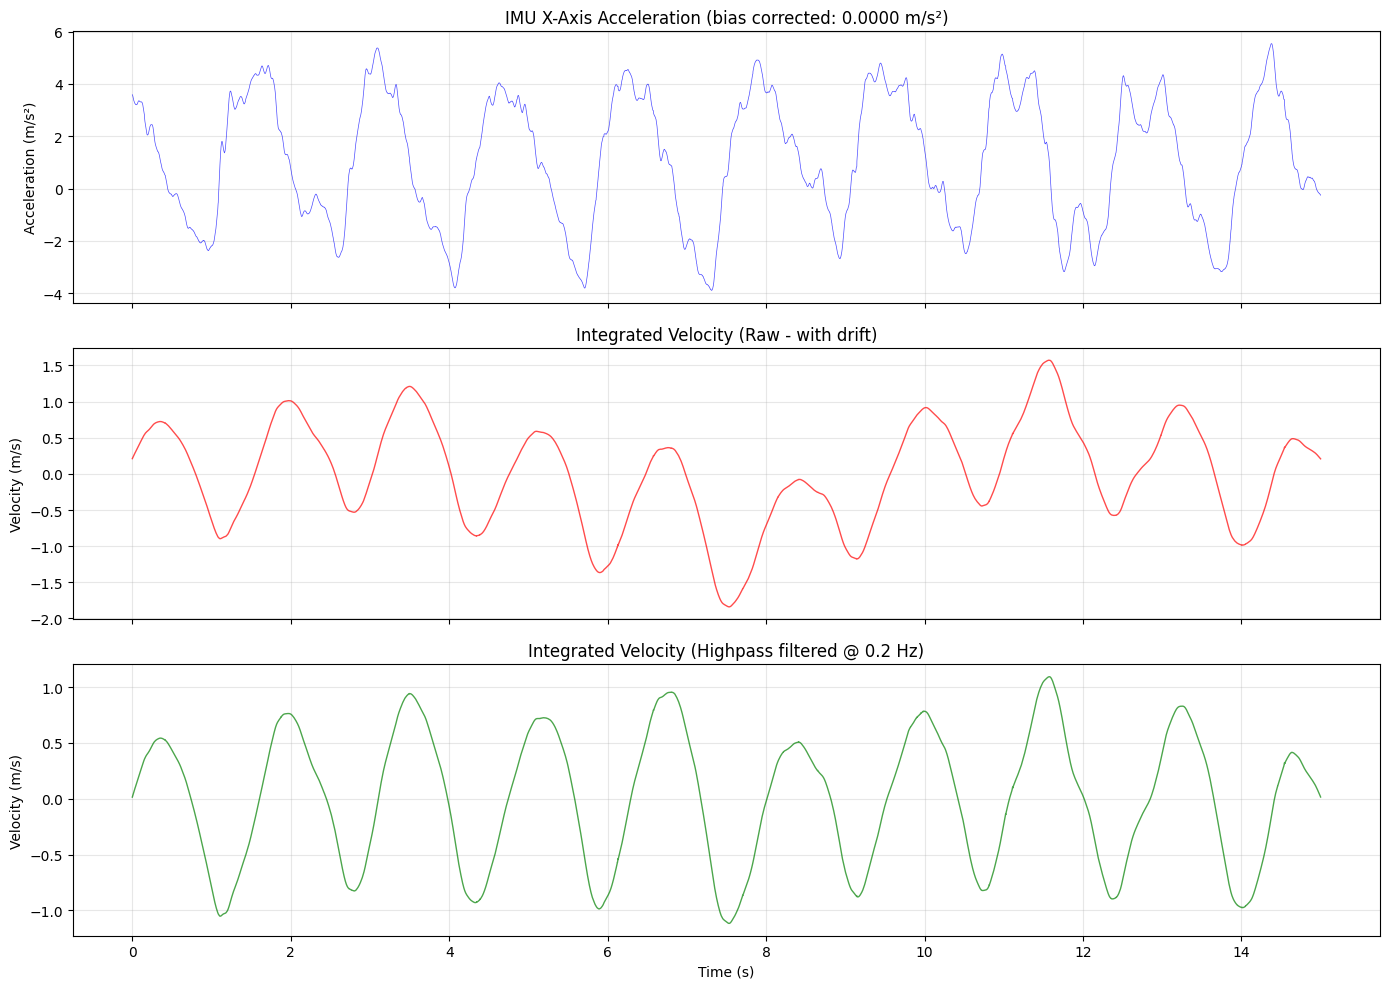

In [12]:

# Visualization: Before vs After drift correction
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

t0 = imu_result['times'][0]
t_rel = imu_result['times'] - t0

# Plot 1: Acceleration
axes[0].plot(t_rel, imu_result['acceleration'], 'b-', linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Acceleration (m/s²)')
axes[0].set_title(f'IMU X-Axis Acceleration (bias corrected: {imu_result["bias"]:.4f} m/s²)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Raw integrated velocity (with drift)
axes[1].plot(t_rel, imu_result['velocity_raw'], 'r-', linewidth=1, alpha=0.7)
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_title('Integrated Velocity (Raw - with drift)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Filtered velocity (drift removed)
axes[2].plot(t_rel, imu_result['velocity_filtered'], 'g-', linewidth=1, alpha=0.7)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Velocity (m/s)')
axes[2].set_title(f'Integrated Velocity (Highpass filtered @ {IMU_HIGHPASS_CUTOFF} Hz)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### <font color='red'>How do i check if there is filter ringing? Or just remove first and last second of data?</font>

### Step 4: Fix CPU Counter Resets

The radar's 32-bit CPU counter can overflow (~21.5 seconds at 200 MHz). 
We detect and correct these resets to maintain a continuous timeline.
Then we fit them again ros time to see if they correlate well.

=== CPU Counter Reset Correction ===
⚠️  Clustering detected 2 segments, 1 resets
⚠️  Detected 1 resets. Stitching 2 segments...
   Gap 1: method=linear_fit, added_offset=4294957034, total=4294957034
✅ CPU counter resets corrected!
   Stitched R² = 0.000000
   Clock freq  = 0.00 MHz


=== CPU Cycle Calibration (Initial Fit to ROS) ===

Linear model: t_ros = 4.9993956807e-09 × cpu_cycles + 1765983767.1691
R² = 1.000000 (should be close to 1.0)
Clock frequency = 200.02 MHz


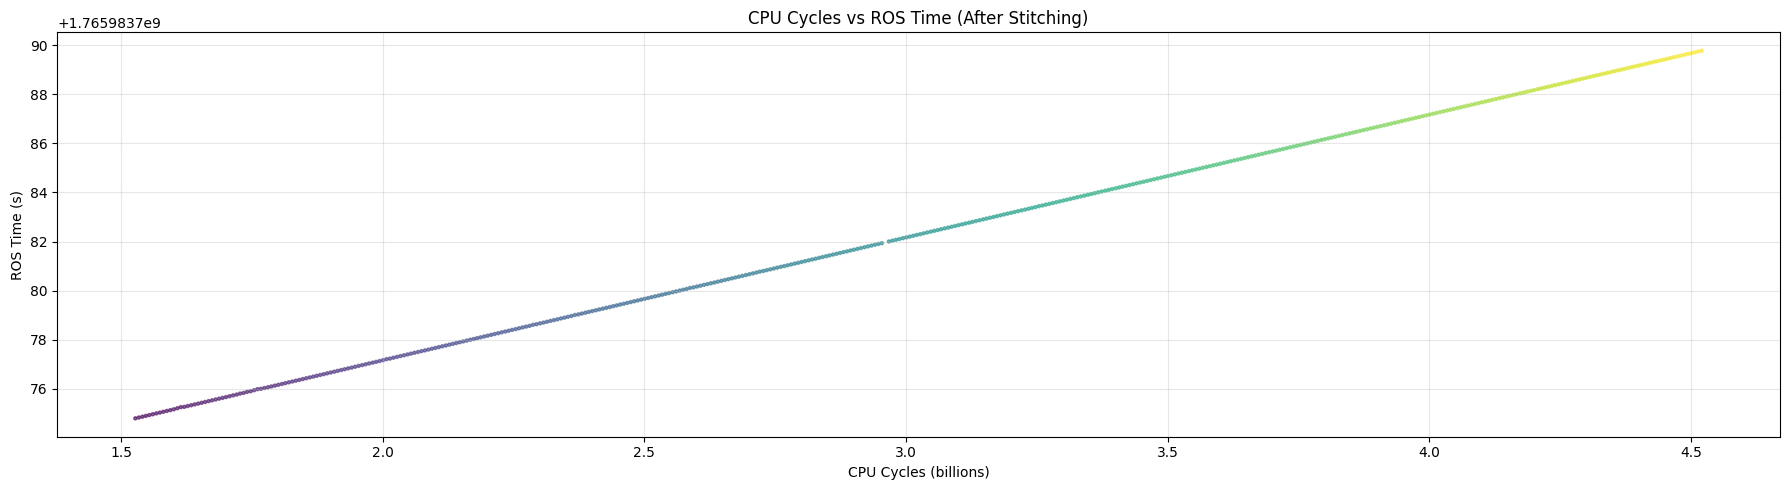

In [13]:
print("=== CPU Counter Reset Correction ===")

# Apply automatic stitching
radar_frames_raw = data.radar_velocity.copy()
data.radar_velocity, stitch_diagnostics = rosbag_loader.stitch_cpu_counter_resets_improved(
    radar_frames_raw, verbose=True
)

if stitch_diagnostics.get("resets_detected", False):
    print(f"✅ CPU counter resets corrected!")
    print(f"   Stitched R² = {stitch_diagnostics.get('r_squared_after', 0):.6f}")
    print(f"   Clock freq  = {stitch_diagnostics.get('clock_freq_mhz', 0):.2f} MHz")
else:
    print(f"✓ No resets detected - data is continuous")



# Linear fit: CPU cycles vs ROS time
times_ros  = np.array([frame.timestamp for frame in data.radar_velocity])
cycles_cpu = np.array([frame.time_cpu_cycles[0] for frame in data.radar_velocity])
slope_init, intercept_init, r_init, _, _ = linregress(
    cycles_cpu, 
    times_ros
)
clock_freq_mhz = 1.0 / slope_init / 1e6

print(f"\n\n=== CPU Cycle Calibration (Initial Fit to ROS) ===")
print(f"\nLinear model: t_ros = {slope_init:.10e} × cpu_cycles + {intercept_init:.4f}")
print(f"R² = {r_init**2:.6f} (should be close to 1.0)")
print(f"Clock frequency = {clock_freq_mhz:.2f} MHz")

# Visualization
fig, ax = plt.subplots(figsize=(18, 5))
# ax.plot(cycles_cpu/1e9, slope_init * cycles_cpu + intercept_init, 'r-', linewidth=2, alpha=0.7, label=f'Linear fit (R²={r_init**2:.6f})')
ax.scatter(cycles_cpu/1e9, times_ros, s=5, alpha=0.6, c=np.arange(len(cycles_cpu)), cmap='viridis')
ax.set_xlabel('CPU Cycles (billions)')
ax.set_ylabel('ROS Time (s)')
ax.set_title('CPU Cycles vs ROS Time (After Stitching)')
# ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### <font color='red'>Investigate Gaps!</font>

### Step 5: Estimate Radar Ego-Velocity

Use Weighted Least Squares to solve for body velocity from Doppler measurements:

$$\mathbf{v}_{body} = \arg\min_{\vec{v}} \sum_{i=1}^{N} w_i (\hat{r}_i \cdot \vec{v} - v_{rad,i})^2$$

where $w_i = \text{intensity}_i$ (trust brighter returns more).

Alternativly use Huber loss.

In [14]:
radar_data = rv_utils.process_radar_frames(
    data.radar_velocity,
    min_intensity=MIN_INTENSITY,
    min_range=MIN_RANGE,
    min_points=MIN_POINTS,
    use_huber=USE_HUBER,
    huber_delta=HUBER_DELTA,
)

# Filter out invalid CPU cycles
print(len(data.radar_velocity))
print(len(radar_data['cpu_cycles']))
radar_data = rv_utils.filter_valid_cpu_cycles(radar_data)
print(len(radar_data['cpu_cycles']))

print(f"=== Radar Velocity Estimates ===\n")
print(f"Valid frames:     {len(radar_data['times_ros'])}")
print(f"ROS time range:   [{radar_data['times_ros'][0]:.2f}, {radar_data['times_ros'][-1]:.2f}] s")
print(f"CPU cycle range:  [{radar_data['cpu_cycles'][0]/1e9:.3f}, {radar_data['cpu_cycles'][-1]/1e9:.3f}] B")
print(f"Vx range:         [{radar_data['vx'].min():.2f}, {radar_data['vx'].max():.2f}] m/s")
print(f"Duration:         {radar_data['times_ros'][-1] - radar_data['times_ros'][0]:.2f} s")

# Verify monotonicity
cpu_monotonic = np.all(np.diff(radar_data['cpu_cycles']) > 0)
ros_monotonic = np.all(np.diff(radar_data['times_ros']) > 0)
print(f"\nMonotonicity:")
print(f"  ROS timestamps: {'✓' if ros_monotonic else '✗'}")
print(f"  CPU cycles:     {'✓' if cpu_monotonic else '✗'}")

449
292
292
=== Radar Velocity Estimates ===

Valid frames:     292
ROS time range:   [1765983774.84, 1765983789.77] s
CPU cycle range:  [1.534, 4.521] B
Vx range:         [-1.69, 3.07] m/s
Duration:         14.93 s

Monotonicity:
  ROS timestamps: ✓
  CPU cycles:     ✓


### Step 6: Filter Radar Velocity

Apply lowpass filter to reduce Doppler noise.

In [15]:
# Compute radar sample rate
time_span = radar_data['times_ros'][-1] - radar_data['times_ros'][0]
sample_rate_radar = len(radar_data['times_ros']) / time_span

print(f"=== Radar Filtering ===\n")
print(f"Sample rate: {sample_rate_radar:.1f} Hz")
print(f"Lowpass cutoff: {RADAR_LOWPASS_CUTOFF} Hz")

if sample_rate_radar > 2 * RADAR_LOWPASS_CUTOFF:
    radar_data['vx_filtered'] = rv_utils.apply_lowpass_filter(
        radar_data['vx'],
        cutoff_hz=RADAR_LOWPASS_CUTOFF,
        sample_rate_hz=sample_rate_radar,
        order=2
    )
    print(f"✓ Filter applied")
    print(f"   Before: [{radar_data['vx'].min():.2f}, {radar_data['vx'].max():.2f}] m/s")
    print(f"   After:  [{radar_data['vx_filtered'].min():.2f}, {radar_data['vx_filtered'].max():.2f}] m/s")
else:
    print(f"✗  Sample rate too low - using unfiltered data")
    radar_data['vx_filtered'] = radar_data['vx'].copy()

=== Radar Filtering ===

Sample rate: 19.6 Hz
Lowpass cutoff: 3.0 Hz
✓ Filter applied
   Before: [-1.69, 3.07] m/s
   After:  [-1.66, 1.29] m/s


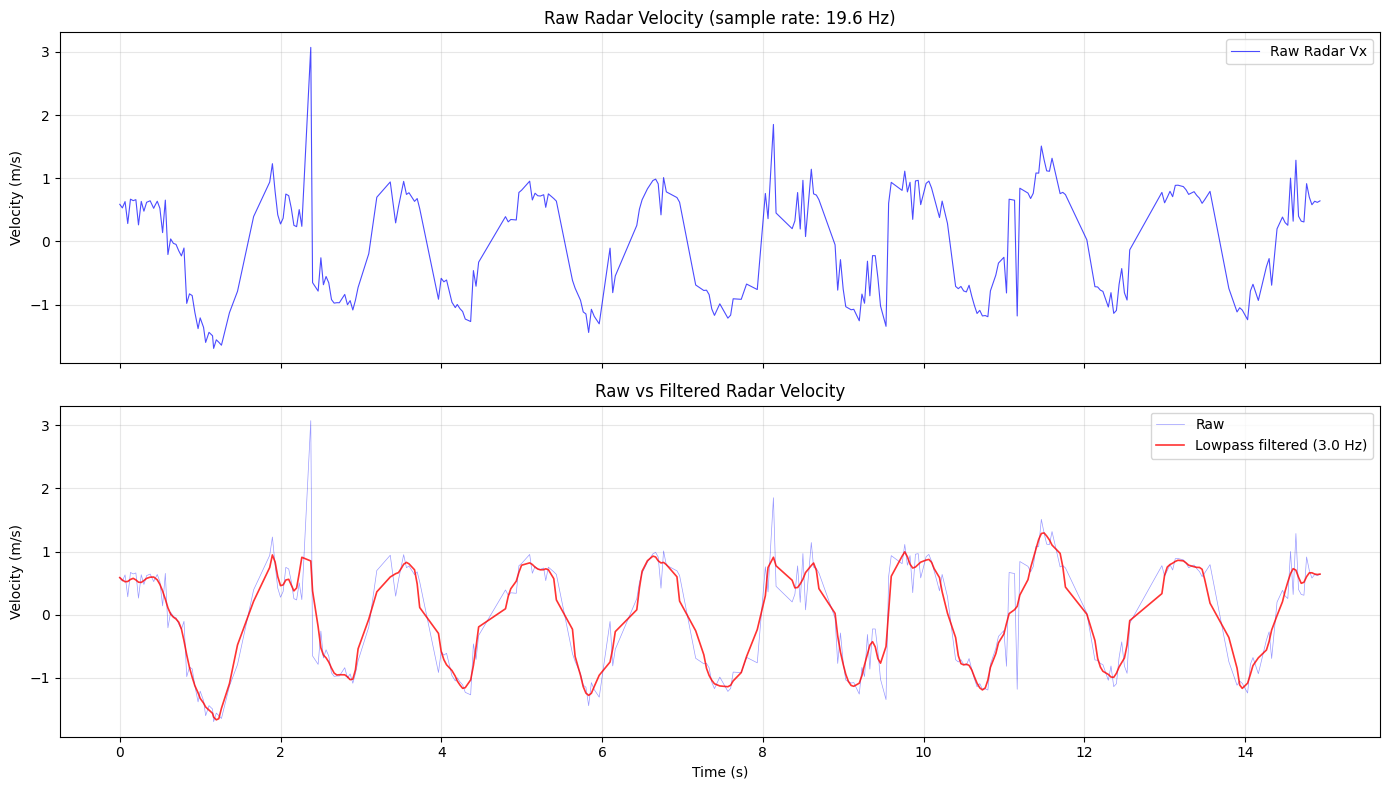


=== Velocity Statistics Comparison ===
Raw velocity:
  Mean: -0.045 m/s
  Std:  0.844 m/s
  Range: [-1.69, 3.07] m/s

Filtered velocity:
  Mean: -0.045 m/s
  Std:  0.779 m/s
  Range: [-1.66, 1.29] m/s

Noise reduction: 7.7%


In [16]:
# Visualize raw vs filtered radar velocity
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

t_rel = radar_data['times_ros'] - radar_data['times_ros'][0]

# Plot 1: Raw radar velocity
axes[0].plot(t_rel, radar_data['vx'], 'b-', linewidth=0.8, alpha=0.7, label='Raw Radar Vx')
axes[0].set_ylabel('Velocity (m/s)')
axes[0].set_title(f'Raw Radar Velocity (sample rate: {sample_rate_radar:.1f} Hz)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Filtered radar velocity
axes[1].plot(t_rel, radar_data['vx'], 'b-', linewidth=0.5, alpha=0.4, label='Raw')
axes[1].plot(t_rel, radar_data['vx_filtered'], 'r-', linewidth=1.2, alpha=0.8, label=f'Lowpass filtered ({RADAR_LOWPASS_CUTOFF} Hz)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_title('Raw vs Filtered Radar Velocity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics comparison
print(f"\n=== Velocity Statistics Comparison ===")
print(f"Raw velocity:")
print(f"  Mean: {np.mean(radar_data['vx']):.3f} m/s")
print(f"  Std:  {np.std(radar_data['vx']):.3f} m/s")
print(f"  Range: [{radar_data['vx'].min():.2f}, {radar_data['vx'].max():.2f}] m/s")

print(f"\nFiltered velocity:")
print(f"  Mean: {np.mean(radar_data['vx_filtered']):.3f} m/s")
print(f"  Std:  {np.std(radar_data['vx_filtered']):.3f} m/s")
print(f"  Range: [{radar_data['vx_filtered'].min():.2f}, {radar_data['vx_filtered'].max():.2f}] m/s")

print(f"\nNoise reduction: {(1 - np.std(radar_data['vx_filtered'])/np.std(radar_data['vx']))*100:.1f}%")

### Step 7: Summary - Prepared Data Structure

All data is now ready for timestamp calibration and optimization.

In [17]:
print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)

print(f"\nRadar Data:")
print(f"  Frames:           {len(radar_data['times_ros'])}")
print(f"  ROS timestamps:   [{radar_data['times_ros'][0]:.2f}, {radar_data['times_ros'][-1]:.2f}] s")
print(f"  CPU cycles:       [{radar_data['cpu_cycles'][0]/1e9:.3f}, {radar_data['cpu_cycles'][-1]/1e9:.3f}] B")
print(f"  Vx (filtered):    [{radar_data['vx_filtered'].min():.2f}, {radar_data['vx_filtered'].max():.2f}] m/s")

print(f"\nIMU Data:")
print(f"  Samples:          {len(imu_result['times'])}")
print(f"  Timestamps:       [{imu_result['times'][0]:.2f}, {imu_result['times'][-1]:.2f}] s")
print(f"  Vx (filtered):    [{imu_result['velocity_filtered'].min():.2f}, {imu_result['velocity_filtered'].max():.2f}] m/s")
print(f"  Sample rate:      {sample_rate_imu:.1f} Hz")

print(f"\nAgiros State:")
print(f"  Samples:          {len(state_times)}")
print(f"  Vx range:         [{state_vx.min():.2f}, {state_vx.max():.2f}] m/s")

print(f"\nInitial CPU Calibration:")
print(f"  Slope:            {slope_init:.10e} s/cycle")
print(f"  Intercept:        {intercept_init:.4f} s")
print(f"  Clock frequency:  {clock_freq_mhz:.2f} MHz")
print(f"  Fit quality (R²): {r_init**2:.6f}")


DATA PREPARATION COMPLETE

Radar Data:
  Frames:           292
  ROS timestamps:   [1765983774.84, 1765983789.77] s
  CPU cycles:       [1.534, 4.521] B
  Vx (filtered):    [-1.66, 1.29] m/s

IMU Data:
  Samples:          14917
  Timestamps:       [1765983774.79, 1765983789.79] s
  Vx (filtered):    [-1.12, 1.09] m/s
  Sample rate:      994.6 Hz

Agiros State:
  Samples:          4503
  Vx range:         [-0.88, 0.78] m/s

Initial CPU Calibration:
  Slope:            4.9993956807e-09 s/cycle
  Intercept:        1765983767.1691 s
  Clock frequency:  200.02 MHz
  Fit quality (R²): 1.000000


## Analysis

### Step 1: Radar Doppler Noise Profile

We assume the measured Doppler Velocity is generated by the following model:

$$v_{d,i} = \vec{v}_{body} \cdot \vec{u}_{i} + \eta_i$$

- $v_{d,i}$ is the measured Doppler
- $\vec{u}_{i}$ is the unit Line-of-Sight (LOS) vector
- $\eta_i$ is the measurement noise (hopefully gaussian)


Calculate Residuals: Select a frame. For every point in that frame, calculate the difference between the measured Doppler and the expected Doppler given your estimate:

$$r_i = v_{d,i} - (\hat{v}_{body} \cdot \vec{u}_{i})$$

Analyze the Residuals ($r$):Plot a histogram of $r$.
Q-Q Plot: This is better than a histogram for detecting tail behavior. Plot the quantiles of your residuals against the quantiles of a standard normal distribution.

=== Doppler Residual Analysis ===

Frames with WLS estimates: 292
Analyzing 6 sample frames:



  Frame 0: 6 points, mean=-0.302 m/s, std=0.537 m/s
  Frame 58: 11 points, mean=-0.181 m/s, std=0.446 m/s
  Frame 116: 7 points, mean=-0.011 m/s, std=0.370 m/s
  Frame 174: 10 points, mean=0.035 m/s, std=0.372 m/s
  Frame 232: 5 points, mean=0.004 m/s, std=0.048 m/s
  Frame 291: 6 points, mean=0.029 m/s, std=0.136 m/s


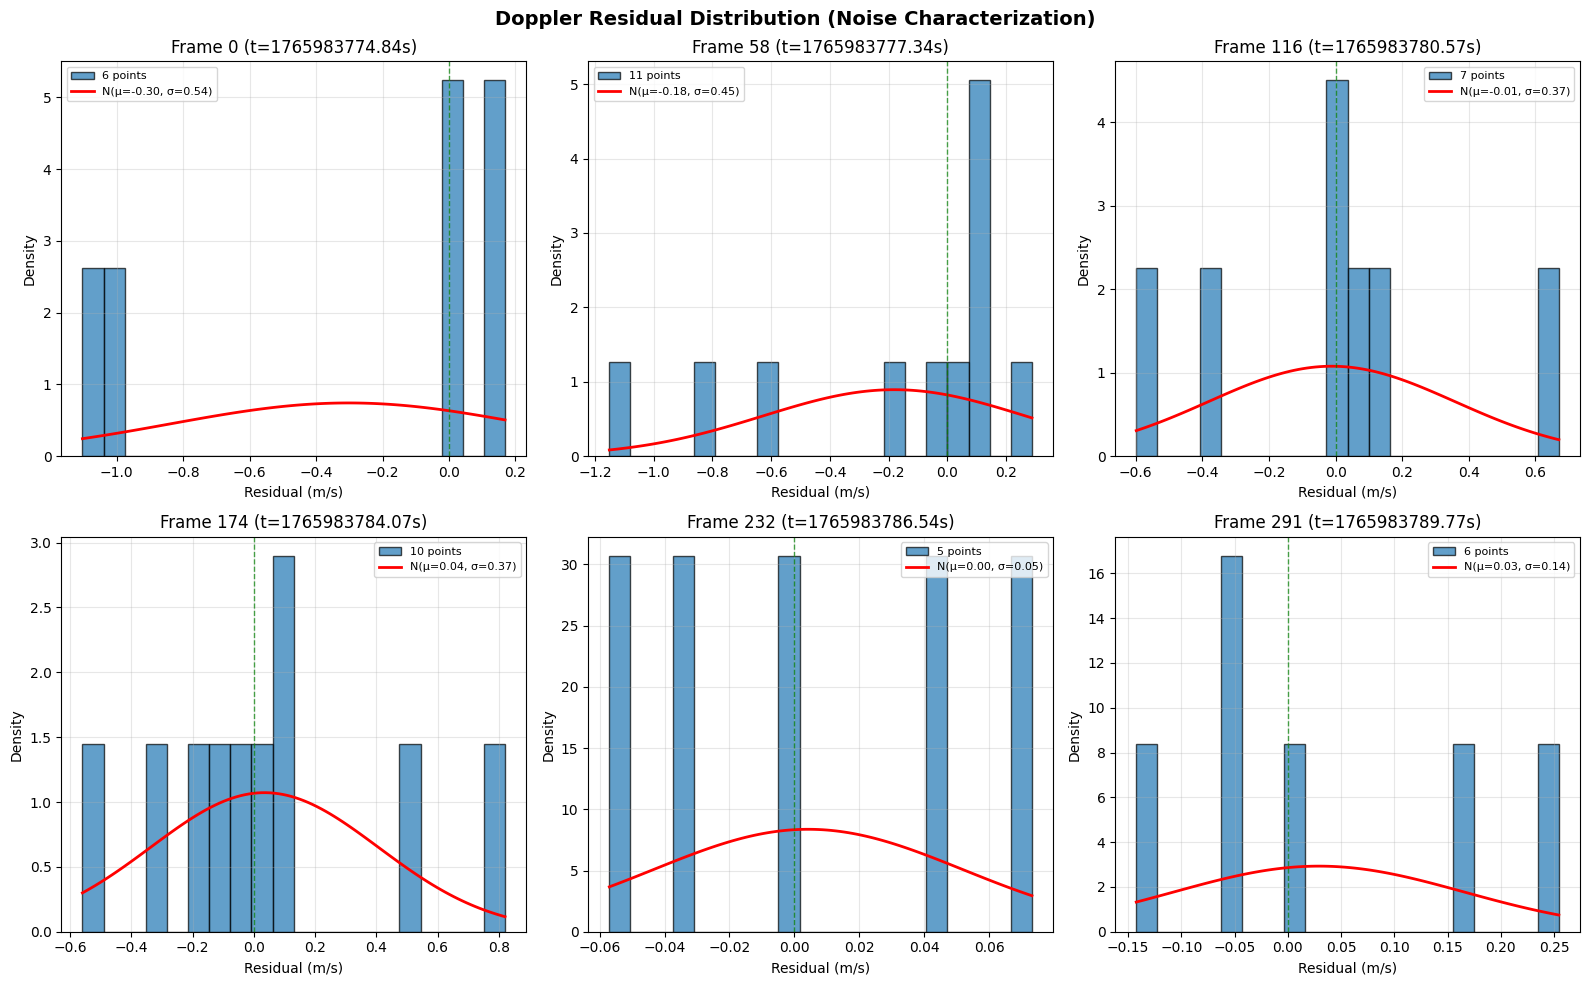


=== Aggregate Residual Analysis ===

Use Huber Loss = True
Huber Delta = 0.5
Total residuals: 1936
Mean:            -0.0077 m/s (should be ≈0)
Std dev:         0.3990 m/s
Skewness:        0.0042
Kurtosis:        2.6601 (excess kurtosis)


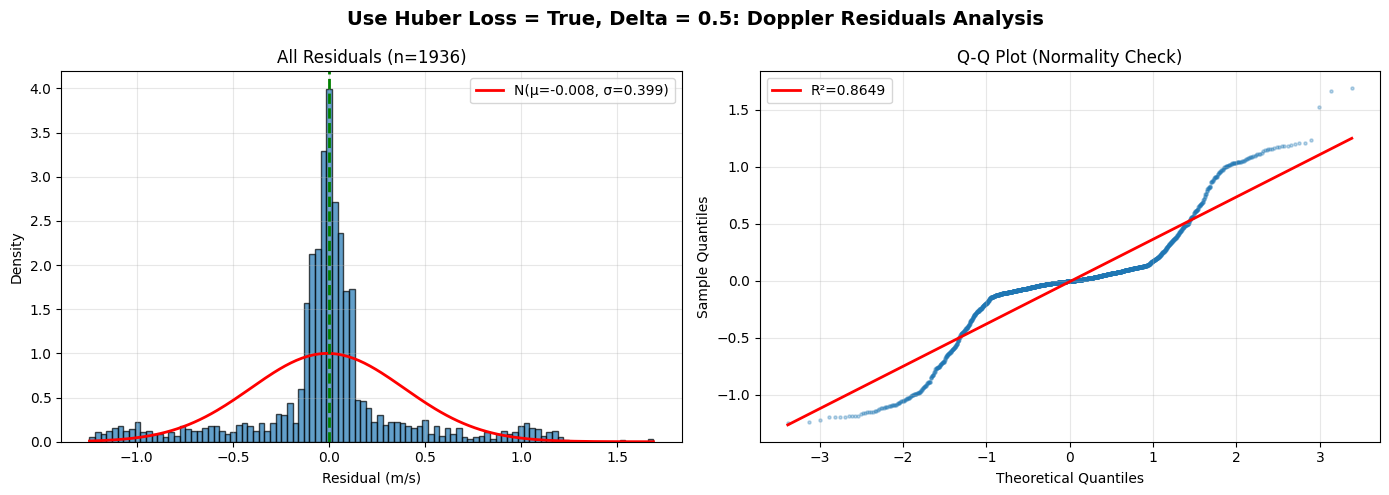

In [18]:
# Residual Analysis: Check if Doppler noise is Gaussian
# For each frame, compute residuals: r_i = v_d,i - (v_body · u_i)

from scipy import stats as sp_stats

print("=== Doppler Residual Analysis ===\n")

# Create a mapping from timestamp to velocity estimate
velocity_lookup = {}
for i in range(len(radar_data['times_ros'])):
    t = radar_data['times_ros'][i]
    velocity_lookup[t] = np.array([
        radar_data['vx'][i],
        radar_data['vy'][i],
        radar_data['vz'][i]
    ])

# Select sample frames that have velocity estimates
sample_frames_with_estimates = []
for frame in data.radar_velocity:
    if frame.timestamp in velocity_lookup:
        sample_frames_with_estimates.append(frame)

print(f"Frames with WLS estimates: {len(sample_frames_with_estimates)}")

# Select a few evenly spaced frames
num_samples = min(6, len(sample_frames_with_estimates))
sample_indices = np.linspace(0, len(sample_frames_with_estimates)-1, num_samples, dtype=int)

print(f"Analyzing {num_samples} sample frames:\n")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, frame_idx in enumerate(sample_indices):
    frame = sample_frames_with_estimates[frame_idx]
    v_body_est = velocity_lookup[frame.timestamp]
    
    # Extract point data
    positions = np.array(frame.positions)
    velocities_measured = np.array(frame.velocities)
    
    # Compute residuals for each point
    residuals = []
    
    for i in range(len(positions)):
        x, y, z = positions[i]
        v_d_measured = velocities_measured[i]
        
        # Range (distance)
        r = np.sqrt(x**2 + y**2 + z**2)
        
        if r > 0:
            # Unit LOS vector
            u_i = np.array([x/r, y/r, z/r])
            
            # Expected Doppler: v_d_expected = v_body · u_i
            v_d_expected = np.dot(v_body_est, u_i)
            
            # Residual: r_i = measured - expected
            residual = v_d_measured - v_d_expected
            residuals.append(residual)
    
    residuals = np.array(residuals)
    
    # Statistics
    mean_r = np.mean(residuals)
    std_r = np.std(residuals)
    
    print(f"  Frame {frame_idx}: {len(residuals)} points, "
          f"mean={mean_r:.3f} m/s, std={std_r:.3f} m/s")
    
    # Plot histogram with Gaussian overlay
    axes[idx].hist(residuals, bins=20, alpha=0.7, edgecolor='black', 
                   density=True, label=f'{len(residuals)} points')
    
    # Fit Gaussian (should be centered at 0)
    x_fit = np.linspace(residuals.min(), residuals.max(), 100)
    gaussian_fit = sp_stats.norm.pdf(x_fit, mean_r, std_r)
    axes[idx].plot(x_fit, gaussian_fit, 'r-', linewidth=2, 
                   label=f'N(μ={mean_r:.2f}, σ={std_r:.2f})')
    axes[idx].axvline(0, color='green', linestyle='--', linewidth=1, alpha=0.7)
    
    axes[idx].set_xlabel('Residual (m/s)')
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'Frame {frame_idx} (t={frame.timestamp:.2f}s)')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Doppler Residual Distribution (Noise Characterization)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Aggregate all residuals for overall noise profile
print("\n=== Aggregate Residual Analysis ===\n")

all_residuals = []
for frame in sample_frames_with_estimates:
    if frame.timestamp not in velocity_lookup:
        continue
    
    v_body_est = velocity_lookup[frame.timestamp]
    positions = np.array(frame.positions)
    velocities_measured = np.array(frame.velocities)
    
    for i in range(len(positions)):
        x, y, z = positions[i]
        v_d_measured = velocities_measured[i]
        r = np.sqrt(x**2 + y**2 + z**2)
        
        if r > 0:
            u_i = np.array([x/r, y/r, z/r])
            v_d_expected = np.dot(v_body_est, u_i)
            residual = v_d_measured - v_d_expected
            all_residuals.append(residual)

all_residuals = np.array(all_residuals)

print("Use Huber Loss =", USE_HUBER)
if USE_HUBER:
    print("Huber Delta =", HUBER_DELTA)
print(f"Total residuals: {len(all_residuals)}")
print(f"Mean:            {np.mean(all_residuals):.4f} m/s (should be ≈0)")
print(f"Std dev:         {np.std(all_residuals):.4f} m/s")
print(f"Skewness:        {sp_stats.skew(all_residuals):.4f}")
print(f"Kurtosis:        {sp_stats.kurtosis(all_residuals):.4f} (excess kurtosis)")

# Overall visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with Gaussian fit
axes[0].hist(all_residuals, bins=100, alpha=0.7, edgecolor='black', density=True)
mean_all = np.mean(all_residuals)
std_all = np.std(all_residuals)
x_fit = np.linspace(all_residuals.min(), all_residuals.max(), 200)
gaussian_fit = sp_stats.norm.pdf(x_fit, mean_all, std_all)
axes[0].plot(x_fit, gaussian_fit, 'r-', linewidth=2, 
             label=f'N(μ={mean_all:.3f}, σ={std_all:.3f})')
axes[0].axvline(0, color='green', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (m/s)')
axes[0].set_ylabel('Density')
axes[0].set_title(f'All Residuals (n={len(all_residuals)})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot
(quantiles, values), (slope, intercept, r) = sp_stats.probplot(all_residuals, dist="norm", plot=None)
axes[1].scatter(quantiles, values, alpha=0.3, s=5)
axes[1].plot(quantiles, slope * quantiles + intercept, 'r-', linewidth=2, 
             label=f'R²={r**2:.4f}')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].set_title('Q-Q Plot (Normality Check)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Use Huber Loss = {USE_HUBER}, Delta = {HUBER_DELTA}: Doppler Residuals Analysis", 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Step 2: Ros Time vs Clock Cycles

Get the std of the ros timestamps.


=== CPU Cycle Calibration (Initial Fit to ROS) ===
Linear model: t_ros = 4.9992333628e-09 × cpu_cycles + 1765983767.1698
R² = 1.000000 (should be > 0.999)
Clock frequency = 200.03 MHz

=== USB Timing Jitter ===
Std dev (σ): 2.350 ms
Max:         21.237 ms
95th %ile:   2.296 ms


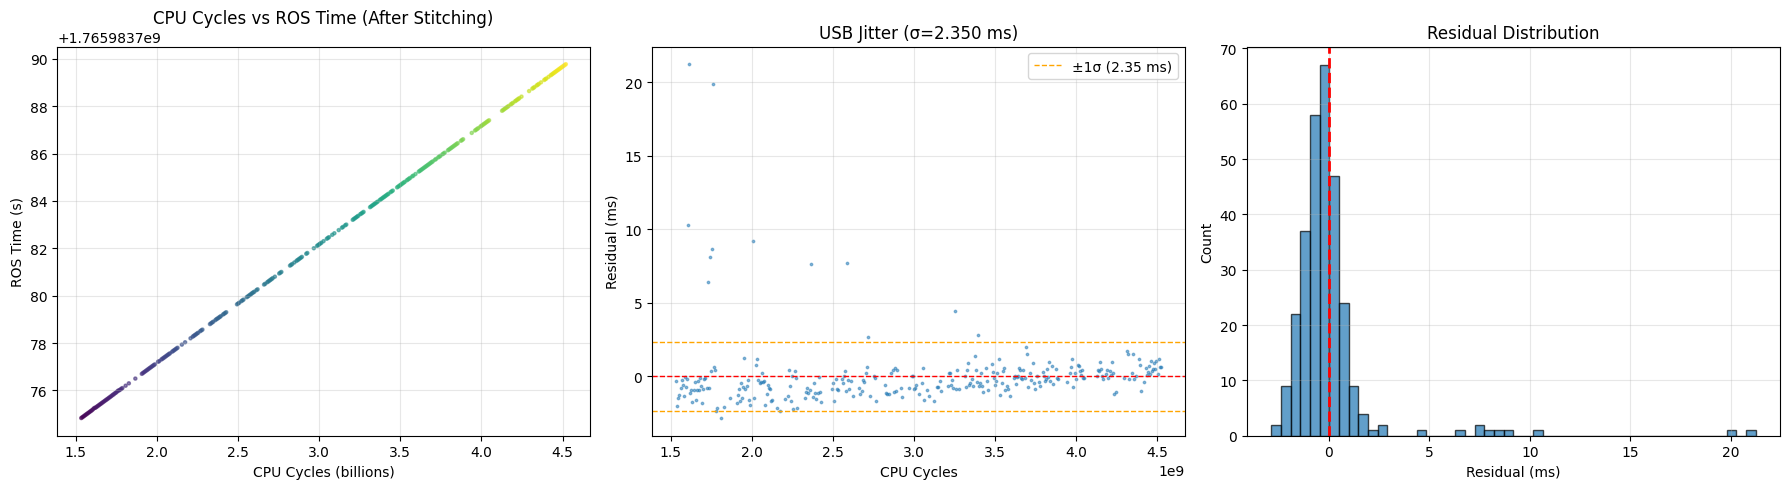

In [19]:
# Linear fit: CPU cycles vs ROS time
slope_init, intercept_init, r_init, _, _ = linregress(
    radar_data['cpu_cycles'], 
    radar_data['times_ros']
)
clock_freq_mhz = 1.0 / slope_init / 1e6

print(f"\n=== CPU Cycle Calibration (Initial Fit to ROS) ===")
print(f"Linear model: t_ros = {slope_init:.10e} × cpu_cycles + {intercept_init:.4f}")
print(f"R² = {r_init**2:.6f} (should be > 0.999)")
print(f"Clock frequency = {clock_freq_mhz:.2f} MHz")

# Compute residuals (USB jitter)
residuals = radar_data['times_ros'] - (slope_init * radar_data['cpu_cycles'] + intercept_init)
usb_jitter_std = np.std(residuals) * 1000  # ms

print(f"\n=== USB Timing Jitter ===")
print(f"Std dev (σ): {usb_jitter_std:.3f} ms")
print(f"Max:         {np.max(np.abs(residuals)) * 1000:.3f} ms")
print(f"95th %ile:   {np.percentile(np.abs(residuals), 95) * 1000:.3f} ms")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: CPU cycles vs ROS time
axes[0].scatter(radar_data['cpu_cycles']/1e9, radar_data['times_ros'], 
                s=5, alpha=0.6, c=np.arange(len(radar_data['cpu_cycles'])), cmap='viridis')
# axes[0].plot(radar_data['cpu_cycles']/1e9, slope_init * radar_data['cpu_cycles'] + intercept_init, 'r-', linewidth=2, alpha=0.7, label=f'Linear fit (R²={r_init**2:.6f})')
axes[0].set_xlabel('CPU Cycles (billions)')
axes[0].set_ylabel('ROS Time (s)')
axes[0].set_title('CPU Cycles vs ROS Time (After Stitching)')
# axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals (USB jitter)
axes[1].scatter(radar_data['cpu_cycles'], residuals * 1000, s=3, alpha=0.5)
axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[1].axhline(usb_jitter_std, color='orange', linestyle='--', linewidth=1, 
                label=f'±1σ ({usb_jitter_std:.2f} ms)')
axes[1].axhline(-usb_jitter_std, color='orange', linestyle='--', linewidth=1)
axes[1].set_xlabel('CPU Cycles')
axes[1].set_ylabel('Residual (ms)')
axes[1].set_title(f'USB Jitter (σ={usb_jitter_std:.3f} ms)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Residual histogram
axes[2].hist(residuals * 1000, bins=50, alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Residual (ms)')
axes[2].set_ylabel('Count')
axes[2].set_title('Residual Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### <font color='red'>Upward Trend = Buffer Float?</font>

This looks like a Queue Buildup in some Buffer (e.g. USB or OS), so that the radar sends data slightly faster than the ROS Node is saving it.


#### <font color='red'>Now asked Gemini:</font>
#### Here are the 4 distinct fixes for a Jetson/ROS 1 setup, ranked from "Must Do" to "Optimization".

##### 1. Maximize Jetson Performance (The "Must Do")

Jetsons aggressively throttle CPU frequencies to save power. If your CPU dips while the radar is firing, the USB buffer fills up.

* **Command:** Run this before starting your ROS stack.
```bash
sudo jetson_clocks

```


* **Why:** This locks the CPU, GPU, and EMC (memory controller) to their maximum frequencies. It eliminates the "startup jitter" and CPU governor lag visible in your plots.

#### 2. Low Latency Flag (If using FTDI/Serial USB)

If your radar connects via a virtual serial port (e.g., `/dev/ttyUSB0` or `/dev/ttyACM0`), Linux defaults to a **16ms latency timer**. It waits 16ms to bundle data before sending an interrupt to the CPU. This creates the "steps" in your latency.

* **Check it:** `cat /sys/bus/usb-serial/devices/ttyUSB0/latency_timer` (likely says 16).
* **Fix it:**
```bash
# Set to 1ms
echo 1 | sudo tee /sys/bus/usb-serial/devices/ttyUSB0/latency_timer

```


*Add a udev rule to make this permanent if you want.*

#### 3. Real-Time Process Priority (`chrt`)

Standard Linux schedules your ROS node alongside GUI, WiFi, and logging tasks. If the scheduler pauses your driver for 2ms, the USB buffer grows. You need to force the scheduler to treat your driver as "Real Time."

* **How to run:**
Instead of `rosrun my_package my_node`, use:
```bash
sudo chrt -f 50 rosrun my_package my_node

```


*(Note: You need `sudo` or configured limits for `chrt`. `-f 50` sets FIFO real-time scheduling at priority 50).*

#### 4. The "Disk I/O" Bottleneck (Rosbag)

If you are recording to the SD card, the "ramp" in your residuals is likely the **disk write buffer** filling up. When `rosbag record` blocks waiting for the SD card, it can block the shared message bus or network stack, causing backpressure on your driver.

* **The Test:** Record to `/dev/shm` (RAM disk) instead of the SD card.
```bash
cd /dev/shm
rosbag record -a

```


* **If the ramp disappears:** Your SD card was too slow. Buy an NVMe SSD or record only specific topics.

#### Summary Checklist for Re-recording

1. **Power:** `sudo jetson_clocks`
2. **USB:** Set latency timer to 1ms (if serial).
3. **Priority:** Launch driver with `chrt -f 50`.
4. **Storage:** Record to RAM (`/dev/shm`) or SSD, not SD card.

**Recommendation:**
Apply **Fix #1 and #2** immediately. They take 30 seconds and will likely flatten that residual plot into a generic Gaussian noise floor, removing the need for complex "Lower Bound" fitting later.

### Step 3: Find Global Time Shift Between Radar and IMU

The radar and IMU clocks are not synchronized. We need to find the optimal time shift $\delta t$ such that:

$$v_{radar}(t + \delta t) \approx v_{IMU}(t)$$

- **Positive $\delta t$**: Radar data is DELAYED (arrives late relative to IMU)
- **Negative $\delta t$**: Radar data is AHEAD (unlikely unless clock sync issue)

We optimize $\delta t$ by minimizing the RMSE between the shifted radar velocity and the IMU velocity.

=== Time Shift Optimization ===

Aligning 14917 IMU samples with 292 Radar samples...
IMU sample rate: 994.6 Hz
Cropping 1.0 s from start/end (~994 samples)

Optimal time shift (δt): -18.8794 ms
Min RMSE:                0.2431 m/s
Correlation:             0.947898

➤ Radar data is DELAYED by 18.9 ms (Standard USB Latency)

=== Alignment Quality ===
RMSE:         0.2431 m/s
Correlation:  0.947898
Residual std: 0.2418 m/s


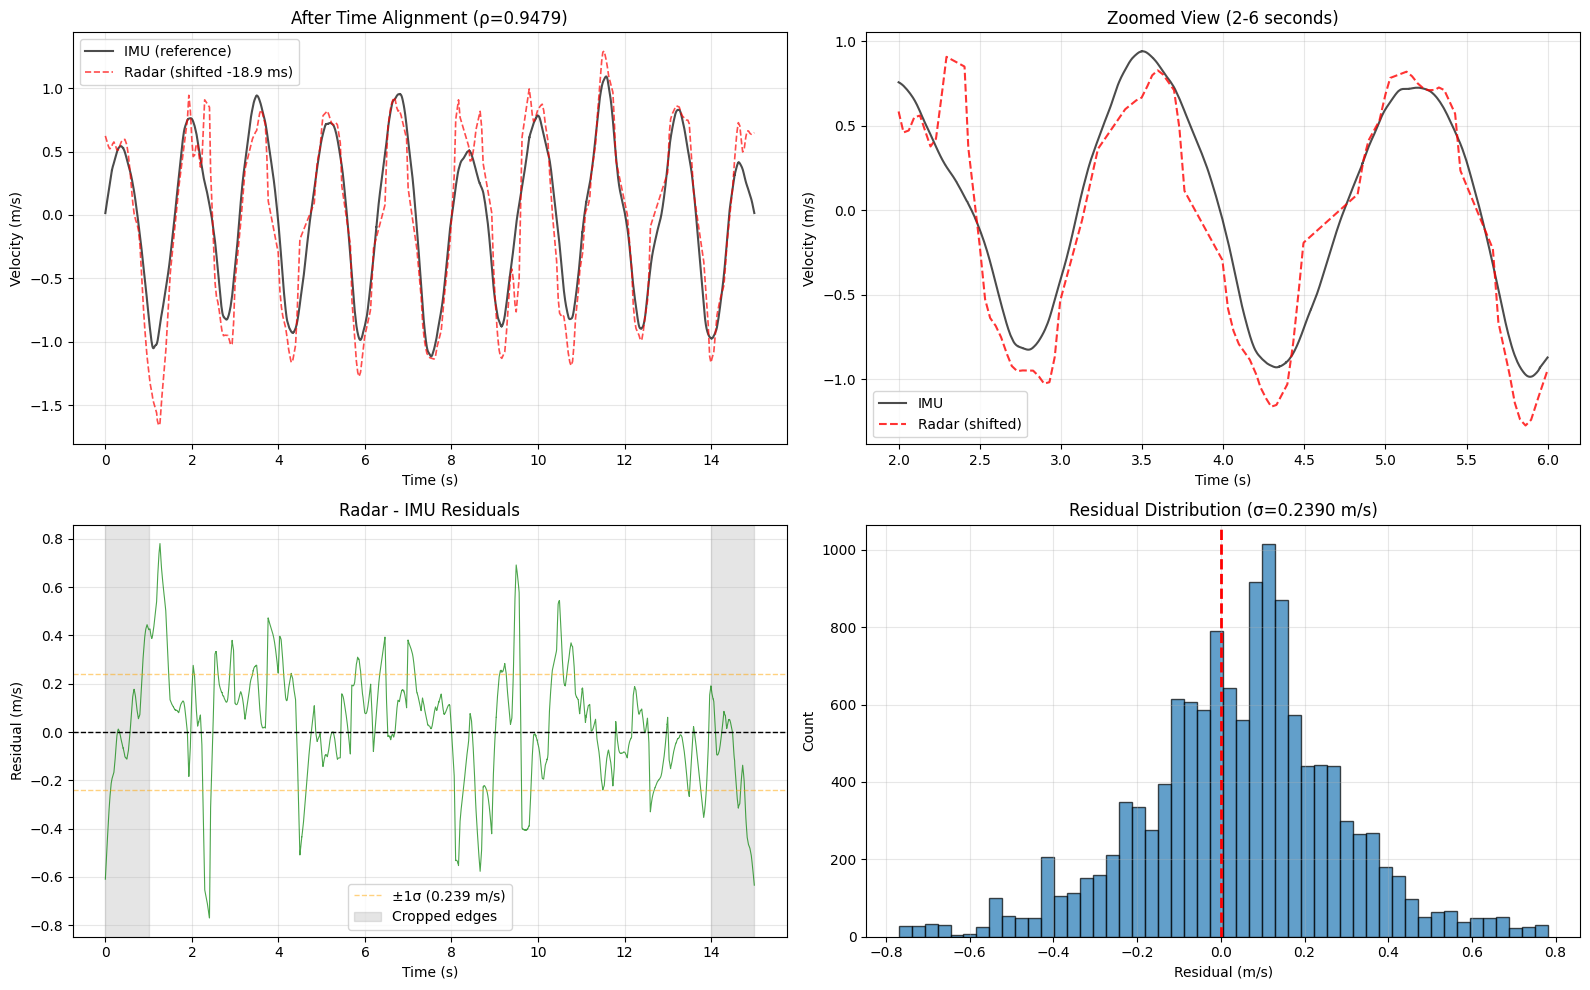


✓ Optimal time shift stored: TIME_SHIFT_DT = -18.8794 ms


In [ ]:
print("=== Time Shift Optimization ===\n")

# Prepare data
t_imu = imu_result['times']
v_imu = imu_result['velocity_filtered']

t_radar = radar_data['times_ros']
v_radar = radar_data['vx_filtered']  # Use filtered for better alignment

print(f"Aligning {len(t_imu)} IMU samples with {len(t_radar)} Radar samples...")

# Compute actual sample rate
imu_sample_rate = len(t_imu) / (t_imu[-1] - t_imu[0])
print(f"IMU sample rate: {imu_sample_rate:.1f} Hz")
print(f"Cropping 1.0 s from start/end (~{int(imu_sample_rate)} samples)")

# Find optimal time shift
optimal_dt, min_rmse, correlation = rv_utils.find_time_shift(
    t_reference=t_imu,
    v_reference=v_imu,
    t_sensor=t_radar,
    v_sensor=v_radar,
    search_window=(-0.2, 0.2),  # Search ±200ms
    crop_duration=1.0  # Crop 1 second from start/end
)

print(f"\nOptimal time shift (δt): {optimal_dt * 1000:.4f} ms")
print(f"Min RMSE:                {min_rmse:.4f} m/s")
print(f"Correlation:             {correlation:.6f}")

# Interpretation: interp(t - dt)
if optimal_dt < 0:
    delay_ms = abs(optimal_dt) * 1000
    print(f"\n➤ Radar data is DELAYED by {delay_ms:.1f} ms")
elif optimal_dt > 0:
    lead_ms = optimal_dt * 1000
    print(f"\n➤ Radar data appears AHEAD by {lead_ms:.1f} ms (Unlikely - check timestamps)")

# Compute alignment metrics
alignment = rv_utils.compute_alignment_metrics(t_imu, v_imu, t_radar, v_radar, optimal_dt, crop_duration=1.0)

print(f"\n=== Alignment Quality ===")
print(f"RMSE:         {alignment['rmse']:.4f} m/s")
print(f"Correlation:  {alignment['correlation']:.6f}")
print(f"Residual std: {np.std(alignment['residuals']):.4f} m/s")

# Visualize alignment
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

t_imu_rel = t_imu - t_imu[0]

# Plot 1: Full time series - before and after
axes[0, 0].plot(t_imu_rel, v_imu, 'k-', linewidth=1.5, alpha=0.7, label='IMU (reference)')
axes[0, 0].plot(t_imu_rel, alignment['v_sensor_aligned'], 'r--', linewidth=1.2, alpha=0.7, 
                label=f'Radar (shifted {optimal_dt*1000:.1f} ms)')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Velocity (m/s)')
axes[0, 0].set_title(f'After Time Alignment (ρ={alignment["correlation"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Zoomed view (2-6 seconds)
zoom_mask = (t_imu_rel >= 2) & (t_imu_rel <= 6)
axes[0, 1].plot(t_imu_rel[zoom_mask], v_imu[zoom_mask], 'k-', linewidth=1.5, alpha=0.7, label='IMU')
axes[0, 1].plot(t_imu_rel[zoom_mask], alignment['v_sensor_aligned'][zoom_mask], 'r--', 
                linewidth=1.5, alpha=0.8, label='Radar (shifted)')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Velocity (m/s)')
axes[0, 1].set_title('Zoomed View (2-6 seconds)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals
crop_idx = alignment['crop_samples']
axes[1, 0].plot(t_imu_rel, alignment['residuals'], 'g-', linewidth=0.8, alpha=0.7)
axes[1, 0].axhline(0, color='k', linestyle='--', linewidth=1)
residual_std = np.std(alignment['residuals'][crop_idx:-crop_idx])
axes[1, 0].axhline(residual_std, color='orange', linestyle='--', linewidth=1, 
                   alpha=0.5, label=f'±1σ ({residual_std:.3f} m/s)')
axes[1, 0].axhline(-residual_std, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axvspan(0, t_imu_rel[crop_idx], alpha=0.2, color='gray', label='Cropped edges')
axes[1, 0].axvspan(t_imu_rel[-crop_idx], t_imu_rel[-1], alpha=0.2, color='gray')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Residual (m/s)')
axes[1, 0].set_title('Radar - IMU Residuals')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residual histogram
axes[1, 1].hist(alignment['residuals'][crop_idx:-crop_idx], bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residual (m/s)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title(f'Residual Distribution (σ={residual_std:.4f} m/s)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store result
TIME_SHIFT_DT = optimal_dt
print(f"\n✓ Optimal time shift stored: TIME_SHIFT_DT = {TIME_SHIFT_DT*1000:.4f} ms")